# Neuroevoluce

Pomocí evolučních algoritmů můžeme vyvíjet i celé neuronové sítě. Buď můžeme evolvovat váhy mezi neurony, strukturu sítě nebo obojí najednou. Nejprve se podíváme, jak naimplementovat jednoduchý algoritmus pro evoluci vah, následně si zkusíme i evoluci vah a struktury sítě najednou pomocí algoritmu NEAT.

## Evoluce vah

Evoluce vah je jednoduchá, stačí naimplementovat jednoduchou neuronovou síť, které umíme nastavit parametry. Náš jedinec v evoluci bude jeden dlouhý vektor, který bude reprezentovat váhy mezi vrstvami v neuronové síti. Při vyhodnocování tedy nastavíme síti váhy podle daného jedince a spočítáme její výstup. Zkusíme si tímto způsobem implementovat klasifikaci na našem oblíbeném datasetu iris.

In [1]:
from sklearn import datasets, model_selection
import numpy as np
import collections
from deap import algorithms, creator, base, benchmarks, cma, tools

Začneme tím, že si připravíme jednoduchou implementaci neuronové sítě. Při inicializaci nastavíme vrstvy, jejich velikosti a také jejich aktivace, jelikož každá vrstva může mít svou vlastní aktivační funkci. Dále budeme potřebovat jednoho dlouhého linárního jedince všech vah rozdělit na váhové matice. To uděláme tak, že budeme brát vždy velikost akutální vrstvy a velikost té následující a na základě toho vezmeme odpovídající část jedince a z něj vytvoříme matici vah. Zároveň musíme přidat biasy, takže velikost aktuální vrstvy zvětšíme ještě o 1. Nakonec bude potřeba ještě funkce pro evaluaci sítě, která vytvořenou síť vyhodnotí tak, že pro každou vrstvu použije odpovídající aktivaci a vrátí nám výstup sítě.

In [3]:
class NeuralNetwork: 
    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        # kontrola, zda pocet akivaci sedi na pocet vrstev
        if len(list(activations)) != len(layer_sizes) - 1:
            raise AttributeError("Number of activations does not match number of layers")
        
        self.activations = list(activations)
        self.vectorized_net = None

    # vraci velikosti vahovych matic mezi vrstvami
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))

    # vezme sit a nastavi hodnoty vahovych matic podle jedince 
    def set_weights(self, vectorized_net):
        
        # kontrola, zda si velikosti odpovidaji
        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}")

        self.vectorized_net = vectorized_net
        self.layers = []
        sum_sizes = 0
        
        # prochazim vrstvy a beru vzdy aktualni a 1 nasledujici a vyrabim vahove matice tim ze vybiram spravnou cast jedince
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            layer = vectorized_net[sum_sizes: sum_sizes + (p + 1) * n]
            self.layers.append(np.reshape(layer, newshape=(p + 1, n))) # reshape do spravneho tvaru
            sum_sizes += (p + 1) * n # soucet velikosti predchozich vrstev pro indexaci


    # vyhodnoceni site
    def eval_network(self, inputs):
        activations = inputs
        
        for act_func, layer in zip(self.activations, self.layers):
            activations_1 = np.append(np.array([1.0]), activations)  # rozsireni matice vah o konstantu 1.0 pro biasy
            activations = act_func(np.dot(activations_1, layer))

        return activations

Nyní si akorát načteme data a rozdělíme si je na trénovací a testovací.

In [4]:
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

Musíme si ještě definovat fitness funkci, což bude pouze vyhodnocení sítě na datech, kdy vždy vybereme predikovanou třídu s maximální pravděpodobností a spočítáme pak celkovou accuracy. Zároveň si definujeme vlastní lineární a relu aktivace.

In [5]:
def relu(x):
    return np.maximum(0,x)

def linear(x):
    return x

def fitness(ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc/len(y),

Pro samotné nastavení vah neuronové sítě použíjeme algoritmus CMA-ES, což je evoluční strategie, která je dobrá na úlohy spojité optimalizace, kterou máme i zde. V evoluční strategii se nevyskytuje křížení, ale místo něj se klade důraz na mutaci. Zde se používá námi známá gaussovská mutace. Evoluční strategii používáme také proto, že nám umožňuje váhy měnit korelovaně, protože si pamatuje celou kovariační matici, ze které generuje jedince. Klasická evoluce umí měnit váhy jen nezávisle na sobě, a dává proto horší výsledky. CMA-ES je implementována v knihovně deap, a je tedy snadné ji použít.

In [5]:
net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()    
    
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness, X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0]*ind_size, sigma=0.1, lambda_=5*ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof)

gen	nevals	avg     	std      	min	max     
0  	215   	0.332849	0.0928229	0  	0.669643
1  	215   	0.344975	0.0951942	0  	0.6875  
2  	215   	0.350706	0.102927 	0  	0.696429
3  	215   	0.35706 	0.0969967	0  	0.696429
4  	215   	0.368023	0.0911327	0  	0.696429
5  	215   	0.368729	0.086709 	0  	0.758929
6  	215   	0.37363 	0.0936554	0.0357143	0.714286
7  	215   	0.387708	0.113457 	0        	0.696429
8  	215   	0.384635	0.114208 	0        	0.696429
9  	215   	0.400083	0.12237  	0        	0.705357
10 	215   	0.405523	0.136936 	0        	0.732143
11 	215   	0.421138	0.151755 	0        	0.794643
12 	215   	0.439452	0.156697 	0        	0.794643
13 	215   	0.429693	0.153887 	0        	0.892857
14 	215   	0.427782	0.153192 	0.00892857	0.964286
15 	215   	0.442982	0.156896 	0         	0.883929
16 	215   	0.459967	0.168208 	0         	0.9375  
17 	215   	0.4424  	0.161015 	0         	0.901786
18 	215   	0.462998	0.169682 	0.107143  	0.982143
19 	215   	0.471013	0.168235 	0.0357143 	0.892857
20 	215

163	215   	0.999751	0.00170418 	0.982143  	1       
164	215   	0.999792	0.00159762 	0.982143  	1       
165	215   	0.999917	0.000857133	0.991071  	1       
166	215   	0.999958	0.000607506	0.991071  	1       
167	215   	0.999958	0.000607506	0.991071  	1       
168	215   	0.999958	0.000607506	0.991071  	1       
169	215   	0.999792	0.00134567 	0.991071  	1       
170	215   	1       	0          	1         	1       
171	215   	0.999834	0.00120647 	0.991071  	1       
172	215   	0.999958	0.000607506	0.991071  	1       
173	215   	0.999834	0.00148227 	0.982143  	1       
174	215   	0.999875	0.0010473  	0.991071  	1       
175	215   	0.999751	0.00147059 	0.991071  	1       
176	215   	0.999502	0.00204966 	0.991071  	1       
177	215   	0.999336	0.00277774 	0.982143  	1       
178	215   	0.999336	0.00249653 	0.982143  	1       
179	215   	0.999626	0.00178813 	0.991071  	1       
180	215   	0.999668	0.00189671 	0.982143  	1       
181	215   	0.999626	0.00178813 	0.991071  	1       
182	215   	0

Na závěr si zkusíme otestovat síť na testovacích datech a změřit na nich accuracy.

In [6]:
fitness(hof[0], test_x, test_y)

(0.9736842105263158,)

## NEAT

Zkusíme se podívat na algoritmus NEAT na příkladu s datasetem iris a zkusíme pro něj najít nejvhodnější síť, která bude umět data nejlépe klasifikovat. Samotná implementace algorimtu není vůbec jednoduchá, ale naštěstí v pythonu existuje knihovna neat-python, kde už tu práci někdo udělal za nás. Knihovna má trochu jiný interface, než na co jsme zvyklí, ale není složité se jí naučit používat. Nastavení parametrů algoritmu se načítá ze zvláštního souboru *config-feedforward*. Dokumentace k jeho formátování se nachází [zde](https://neat-python.readthedocs.io/en/latest/config_file.html). Potom už stačí jen algoritmus spustit. Níže uvedený příklad vychází z dokumentace k [neat-python](https://github.com/CodeReclaimers/neat-python/tree/master/examples/xor) upravený pro naši klasifikaci irisů.


 ****** Running generation 0 ****** 

Population's average fitness: 35.21333 stdev: 13.68483
Best fitness: 78.00000 - size: (3, 12) - species 1 - id 29
Species length: 1 totaling 150 individuals
Species no improv: {1: 0}
Average adjusted fitness: 0.451
Spawn amounts: [150]
Species fitness  : [0.45145299145299145]
Mean genetic distance 1.143396194105389, std dev 0.291276720242495
Total extinctions: 0
Generation time: 0.762 sec

 ****** Running generation 1 ****** 

Population's average fitness: 41.38667 stdev: 15.28781
Best fitness: 78.00000 - size: (3, 12) - species 1 - id 29
Species length: 1 totaling 150 individuals
Species no improv: {1: 1}
Average adjusted fitness: 0.531
Spawn amounts: [150]
Species fitness  : [0.5305982905982906]
Mean genetic distance 1.3215694558620865, std dev 0.3093897051142212
Total extinctions: 0
Generation time: 0.783 sec (0.772 average)

 ****** Running generation 2 ****** 

Population's average fitness: 44.14667 stdev: 13.11202
Best fitness: 78.00000 - si

Species fitness  : [0.36518236742000443, 0.39797739440809043]
Mean genetic distance 1.9299812037011126, std dev 0.33048955037836325
Total extinctions: 0
Generation time: 0.571 sec (0.652 average)

 ****** Running generation 19 ****** 

Population's average fitness: 55.10000 stdev: 18.51621
Best fitness: 109.00000 - size: (4, 11) - species 1 - id 2078
Species length: 2 totaling 150 individuals
Species no improv: {1: 3, 2: 5}
Average adjusted fitness: 0.428
Spawn amounts: [63, 87]
Species fitness  : [0.46006144393241166, 0.39681994966826817]
Mean genetic distance 2.013898225645336, std dev 0.359082028044186
Total extinctions: 0
Generation time: 0.691 sec (0.659 average)

 ****** Running generation 20 ****** 

Population's average fitness: 58.55333 stdev: 20.36583
Best fitness: 109.00000 - size: (4, 11) - species 2 - id 2078
Species length: 2 totaling 150 individuals
Species no improv: {1: 4, 2: 6}
Average adjusted fitness: 0.401
Spawn amounts: [23, 127]
Species fitness  : [0.412175015852

Population's average fitness: 61.03333 stdev: 19.82437
Best fitness: 106.00000 - size: (5, 11) - species 1 - id 5143
Species length: 2 totaling 150 individuals
Species no improv: {1: 19, 3: 9}
Average adjusted fitness: 0.546
Spawn amounts: [35, 115]
Species fitness  : [0.5348780487804877, 0.5561467889908257]
Mean genetic distance 2.0222892971561066, std dev 0.3759662918506996
Total extinctions: 0
Generation time: 0.557 sec (0.576 average)

 ****** Running generation 36 ****** 

Population's average fitness: 58.52667 stdev: 18.61028
Best fitness: 106.00000 - size: (5, 11) - species 1 - id 5143
Species length: 2 totaling 150 individuals
Species no improv: {1: 20, 3: 10}

Species 1 with 73 members is stagnated: removing it
Average adjusted fitness: 0.318
Spawn amounts: [150]
Species fitness  : [0.31764069264069267]
Mean genetic distance 1.671355325979286, std dev 0.2996696841088169
Total extinctions: 0
Generation time: 0.535 sec (0.572 average)

 ****** Running generation 37 ****** 

Popu

Population's average fitness: 62.10000 stdev: 19.52597
Best fitness: 107.00000 - size: (5, 10) - species 4 - id 7037
Species length: 2 totaling 150 individuals
Species no improv: {4: 5, 5: 2}
Average adjusted fitness: 0.378
Spawn amounts: [97, 53]
Species fitness  : [0.41080669710806694, 0.3461187214611872]
Mean genetic distance 1.796270172015371, std dev 0.3511676659890839
Total extinctions: 0
Generation time: 0.592 sec (0.688 average)

 ****** Running generation 54 ****** 

Population's average fitness: 66.57333 stdev: 20.33006
Best fitness: 107.00000 - size: (5, 10) - species 4 - id 7037
Species length: 2 totaling 150 individuals
Species no improv: {4: 6, 5: 3}
Average adjusted fitness: 0.429
Spawn amounts: [42, 108]
Species fitness  : [0.3804223744292238, 0.47716894977168944]
Mean genetic distance 2.0154224161729637, std dev 0.2631834096218876
Total extinctions: 0
Generation time: 0.596 sec (0.693 average)

 ****** Running generation 55 ****** 

Population's average fitness: 64.933

Population's average fitness: 65.70667 stdev: 22.85740
Best fitness: 108.00000 - size: (5, 8) - species 5 - id 10093
Species length: 4 totaling 150 individuals
Species no improv: {4: 7, 5: 5, 6: 6, 7: 0}
Average adjusted fitness: 0.605
Spawn amounts: [75, 29, 21, 25]
Species fitness  : [0.6206275720164608, 0.5773420479302832, 0.6078703703703704, 0.6161265432098766]
Mean genetic distance 2.2225709594728587, std dev 0.46268881572599213
Total extinctions: 0
Generation time: 0.601 sec (0.588 average)

 ****** Running generation 71 ****** 

Population's average fitness: 68.12667 stdev: 22.20910
Best fitness: 108.00000 - size: (5, 9) - species 6 - id 10124
Species length: 4 totaling 150 individuals
Species no improv: {4: 8, 5: 6, 6: 7, 7: 1}
Average adjusted fitness: 0.461
Spawn amounts: [39, 55, 29, 27]
Species fitness  : [0.567037037037037, 0.487843137254902, 0.42141414141414146, 0.36844444444444446]
Mean genetic distance 2.1470092731058665, std dev 0.44262547060981594
Total extinctions: 0

Mean genetic distance 2.186711267306423, std dev 0.47542666708720377
Total extinctions: 0
Generation time: 0.539 sec (0.552 average)

 ****** Running generation 87 ****** 

Population's average fitness: 66.27333 stdev: 22.89218
Best fitness: 108.00000 - size: (7, 8) - species 7 - id 10665
Species length: 2 totaling 150 individuals
Species no improv: {7: 17, 8: 0}
Average adjusted fitness: 0.414
Spawn amounts: [146, 4]
Species fitness  : [0.5662509170946441, 0.26170212765957446]
Mean genetic distance 2.397696054739612, std dev 0.4821792111121117
Total extinctions: 0
Generation time: 0.555 sec (0.551 average)

 ****** Running generation 88 ****** 

Population's average fitness: 68.14667 stdev: 22.83751
Best fitness: 108.00000 - size: (7, 8) - species 7 - id 10665
Species length: 2 totaling 150 individuals
Species no improv: {7: 18, 8: 0}
Average adjusted fitness: 0.447
Spawn amounts: [131, 19]
Species fitness  : [0.6131348965994635, 0.27998088867654086]
Mean genetic distance 2.1023180652

input array([6.2, 2.8, 4.8, 1.8]), expected output 2, got [8.75651076269652e-27, 6.033452008775747e-08, 9.545194785276766e-08]
input array([6.5, 3. , 5.5, 1.8]), expected output 2, got [8.75651076269652e-27, 4.09728760516342e-09, 4.645143179880787e-08]
input array([4.8, 3.4, 1.6, 0.2]), expected output 0, got [0.9993744930458247, 0.013020273858768392, 2.0732717911602186e-08]
input array([6.7, 3.1, 4.7, 1.5]), expected output 1, got [8.75651076269652e-27, 8.859983493800828e-08, 1.1493471003079705e-08]
input array([5.7, 2.8, 4.1, 1.3]), expected output 1, got [8.75651076269652e-27, 8.884539859453797e-07, 6.882097367657258e-08]
input array([6.4, 2.8, 5.6, 2.2]), expected output 2, got [8.75651076269652e-27, 2.7901617968898323e-09, 2.0042862760814107e-07]
input array([5.5, 2.3, 4. , 1.3]), expected output 1, got [8.75651076269652e-27, 1.3046734415341857e-06, 1.1123580497309662e-07]
input array([4.9, 2.4, 3.3, 1. ]), expected output 1, got [1.7398794853601733e-21, 1.9211597622611964e-05, 1.

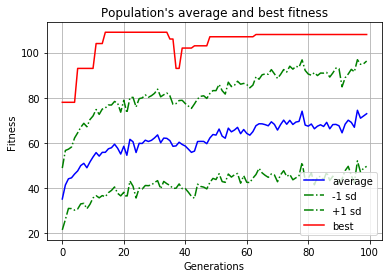

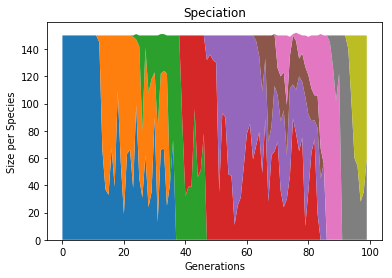

In [9]:
import neat
import visualize
import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/katie/Anaconda3/Library/bin/graphviz'

# vytvoreni a vyhodnoceni site v neatu - fitness funkce
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config) 
        for xi, xo in zip(train_x, train_y): 
            output = net.activate(xi)
            if np.argmax(output) == xo:
                genome.fitness += 1

def run(config_file):
    
    # nacteme konfiguraci neatu 
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    # vytvorime novou populaci
    p = neat.Population(config)

    # pridame statisticke vypocty pro logovani evoluce    
    p.add_reporter(neat.StdOutReporter())
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    
    # pustime pro dany pocet generaci
    winner = p.run(eval_genomes, 100)

    # zobrazime nejlepsiho jedince a jeho vystup
    print('\nBest genome:\n{!s}'.format(winner))
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(train_x, train_y):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    # vykresluje nejlepsi sit
    node_names = {-1:'x1', -2: 'x2', -3: 'x3', -4: 'x4', 0:'setosa', 1:'virginica', 2:'versicolor'}
    visualize.draw_net(config, winner, True, node_names=node_names) 
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)

if __name__ == '__main__':
    # urceni cesty ke konfiguracnimu souboru
    config_path = os.path.join('.', 'config-feedforward')
    run(config_path)

## Úkol na cvičení

Zkuste si pohrát s NEATem a vyskoušet si ho třeba na OpenAI Gym, který jsme dělali na druhém cvičení. Bude potřeba upravit  fitness funkci, tedy místo accuracy dát odměnu za hru a také bude potřeba změnit pár věcí v konfiguračním souborum například parametry počáteční sítě a podmínky, kdy má algoritmus skončit. [Zde](https://github.com/CodeReclaimers/neat-python/tree/master/examples/openai-lander) je pro inspiraci vyřešený [LunarLander](https://gym.openai.com/envs/LunarLander-v2/). Můžete si vybrat libovolný z [problémů](https://gym.openai.com/envs/#classic_control) z knihovny gym a zkusit vytvořit a natrénovat neuronovou síť pomocí neuroevoluce. 
